# 005 RL/DQL In Trading

#### In this project, we explore the application of Reinforcement Learning (RL) / Deep Q-Learning (DQL)—to the domain of algorithmic trading and portfolio management. Reinforcement Learning offers a powerful framework for training agents that learn to make sequential decisions through interaction with a dynamic environment. Unlike supervised learning, RL does not rely on labeled data but instead optimizes behavior through trial and error, guided by rewards and penalties.

- Fernando Lopez
- Ricardo Ibarra
- Marcos Ramos


# 1. DESCARGAR Y PREPARAR DATOS

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from collections import deque
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo: {device}")

np.random.seed(42)
torch.manual_seed(42)

Dispositivo: cpu


In [ ]:
def compute_rsi(series, window=14):
    """Calcula el RSI estándar."""
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.rolling(window=window, min_periods=window).mean()
    ma_down = down.rolling(window=window, min_periods=window).mean()
    rs = ma_up / ma_down
    rsi = 100 - (100 / (1 + rs))
    return rsi

print("Descargando datos de QQQ-USD...")
QQQ = yf.download('QQQ', period='5y', interval='1d')

QQQ = QQQ[['Close']].dropna().copy()

QQQ['SMA_10'] = QQQ['Close'].rolling(window=10).mean()
QQQ['SMA_50'] = QQQ['Close'].rolling(window=50).mean()
QQQ['RSI_14'] = compute_rsi(QQQ['Close'], window=14)

# Normalización estándar
QQQ['Close_Norm'] = (QQQ['Close'] - QQQ['Close'].mean()) / QQQ['Close'].std()
QQQ['SMA_10_Norm'] = (QQQ['SMA_10'] - QQQ['SMA_10'].mean()) / QQQ['SMA_10'].std()
QQQ['SMA_50_Norm'] = (QQQ['SMA_50'] - QQQ['SMA_50'].mean()) / QQQ['SMA_50'].std()
QQQ['RSI_14_Norm'] = (QQQ['RSI_14'] - QQQ['RSI_14'].mean()) / QQQ['RSI_14'].std()

QQQ = QQQ.dropna().reset_index()

print("Datos preparados:")
display(QQQ.head(10))


Descargando datos de QQQ-USD...


/tmp/ipython-input-36-3003947616.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  QQQ = yf.download('QQQ', period='5y', interval='1d')
[*********************100%***********************]  1 of 1 completed


Datos preparados:


Price,Date,Close,SMA_10,SMA_50,RSI_14,Close_Norm,SMA_10_Norm,SMA_50_Norm,RSI_14_Norm
Ticker,,QQQ,,,,,,,
0,2020-09-24,257.705505,262.765671,265.509076,33.992361,-1.380691,-1.332414,-1.348592,-1.310651
1,2020-09-25,263.696869,262.873453,265.750671,41.549469,-1.306987,-1.331071,-1.345434,-0.853926
2,2020-09-28,269.173584,263.071542,266.095974,55.742029,-1.239614,-1.328603,-1.340922,0.003824
3,2020-09-29,267.959839,262.769550,266.274065,48.290527,-1.254545,-1.332366,-1.338594,-0.446519
4,2020-09-30,269.795044,263.083194,266.542849,55.208285,-1.231969,-1.328458,-1.335082,-0.028434
5,2020-10-01,274.077332,264.241650,266.879218,60.665183,-1.179289,-1.314022,-1.330686,0.301363
6,2020-10-02,266.367279,264.964105,267.195779,49.274105,-1.274136,-1.305020,-1.326549,-0.387075
7,2020-10-05,272.047852,266.192474,267.673533,50.909038,-1.204255,-1.289713,-1.320305,-0.288265
8,2020-10-06,267.192688,266.452713,267.965623,50.450463,-1.263982,-1.286470,-1.316488,-0.315980


# 2. SPLIT DE DATOS

In [ ]:
# Porcentaje para entrenamiento
train_ratio = 0.7
n_total = len(QQQ)
n_train = int(n_total * train_ratio)

# Split de datos
train_data = QQQ.iloc[:n_train].reset_index(drop=True)
test_data = QQQ.iloc[n_train:].reset_index(drop=True)

print(f"Observaciones total: {n_total}")
print(f"Entrenamiento: {n_train} filas ({train_ratio*100:.1f}%)")
print(f"Prueba: {n_total - n_train} filas ({(1-train_ratio)*100:.1f}%)")

print("\nRango de fechas entrenamiento:", train_data['Date'].min(), "->", train_data['Date'].max())
print("Rango de fechas prueba:", test_data['Date'].min(), "->", test_data['Date'].max())

display(train_data.head(3))
display(test_data.head(3))

Observaciones total: 1206
Entrenamiento: 844 filas (70.0%)
Prueba: 362 filas (30.0%)

Rango de fechas entrenamiento: 2020-09-24 00:00:00 -> 2024-02-01 00:00:00
Rango de fechas prueba: 2024-02-02 00:00:00 -> 2025-07-15 00:00:00


Price,Date,Close,SMA_10,SMA_50,RSI_14,Close_Norm,SMA_10_Norm,SMA_50_Norm,RSI_14_Norm
Ticker,,QQQ,,,,,,,
0,2020-09-24,257.705505,262.765671,265.509076,33.992361,-1.380691,-1.332414,-1.348592,-1.310651
1,2020-09-25,263.696869,262.873453,265.750671,41.549469,-1.306987,-1.331071,-1.345434,-0.853926
2,2020-09-28,269.173584,263.071542,266.095974,55.742029,-1.239614,-1.328603,-1.340922,0.003824


Price,Date,Close,SMA_10,SMA_50,RSI_14,Close_Norm,SMA_10_Norm,SMA_50_Norm,RSI_14_Norm
Ticker,,QQQ,,,,,,,
0,2024-02-02,425.362823,420.644318,401.536467,68.850525,0.681784,0.634924,0.429115,0.796057
1,2024-02-05,424.807648,421.310605,402.348668,68.163575,0.674954,0.643227,0.439730,0.754540
2,2024-02-06,423.954895,421.718106,403.112363,70.114496,0.664464,0.648305,0.449710,0.872447


# 3. AMBIENTE DE TRADING

In [ ]:
class TradingEnv:
    """
    Entorno de trading: solo una posición a la vez (flat, long o short).
    Acciones: 0=Buy (ir long o cerrar short), 1=Hold, 2=Sell (ir short o cerrar long).
    """
    def __init__(self, data, initial_balance=10000):
        self.data = data.reset_index(drop=True)
        self.n_steps = len(data)
        self.initial_balance = initial_balance
        self.reset()

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.position = 0  # 0 = flat, 1 = long, -1 = short
        self.entry_price = 0
        self.done = False
        self.trades = []
        self.total_asset = self.balance
        return self._get_state()

    def _get_state(self):
        row = self.data.iloc[self.current_step]
        state = [
            float(row['Close_Norm']),
            float(row['SMA_10_Norm']),
            float(row['SMA_50_Norm']),
            float(row['RSI_14_Norm']),
            float(self.position)
        ]
        return np.array(state, dtype=np.float32)

    def step(self, action):
        row = self.data.iloc[self.current_step]
        price = float(row['Close'])
        reward = 0

        # Buy: si flat -> abrir long; si short -> cerrar short y abrir long; si long -> nada
        if action == 0:
            if self.position == 0:
                self.position = 1
                self.entry_price = price
                self.trades.append(('buy', self.current_step, price, 1))
            elif self.position == -1:
                # Cerrar short
                reward = self.entry_price - price  # Ganancia/pérdida short
                self.balance += self.entry_price - price
                self.position = 1
                self.entry_price = price
                self.trades.append(('close_short_open_long', self.current_step, price, 1))
            # Si ya está long, no hace nada

        # Sell: si flat -> abrir short; si long -> cerrar long y abrir short; si short -> nada
        elif action == 2:
            if self.position == 0:
                self.position = -1
                self.entry_price = price
                self.trades.append(('sell', self.current_step, price, -1))
            elif self.position == 1:
                # Cerrar long
                reward = price - self.entry_price  # Ganancia/pérdida long
                self.balance += price - self.entry_price
                self.position = -1
                self.entry_price = price
                self.trades.append(('close_long_open_short', self.current_step, price, -1))
            # Si ya está short, no hace nada

        # Hold: no cambia nada

        self.current_step += 1
        if self.current_step >= self.n_steps - 1:
            self.done = True
            # Cierra cualquier posición abierta al final
            if self.position == 1:
                final_price = float(self.data.iloc[self.current_step]['Close'])
                pnl = final_price - self.entry_price
                self.balance += pnl
                reward += pnl
                self.trades.append(('liquidate_long', self.current_step, final_price, 0))
            elif self.position == -1:
                final_price = float(self.data.iloc[self.current_step]['Close'])
                pnl = self.entry_price - final_price
                self.balance += pnl
                reward += pnl
                self.trades.append(('liquidate_short', self.current_step, final_price, 0))
            self.position = 0
            self.entry_price = 0

        self.total_asset = self.balance  # Siempre es cash, ya que las posiciones se liquidan en el balance
        if self.position != 0:
            # Si hay posición abierta, suma/unifica el valor no realizado
            current_price = float(self.data.iloc[self.current_step - 1]['Close'])
            if self.position == 1:
                self.total_asset += current_price - self.entry_price
            elif self.position == -1:
                self.total_asset += self.entry_price - current_price

        return self._get_state(), reward, self.done, {
            'balance': self.balance,
            'position': self.position,
            'asset': self.total_asset
        }

    def render(self):
        print(f"Step: {self.current_step}, Balance: {self.balance:.2f}, Posición: {self.position}, Asset: {self.total_asset:.2f}")


# 4. RED NEURONAL DQN

In [ ]:
class DQN(nn.Module):
    """
    Red neuronal profunda para aproximar la función Q(s, a).
    - Entradas: vector de estado (features técnicas + inventario actual)
    - Salidas: valor Q para cada acción (Buy, Hold, Sell)
    Arquitectura:
      - 3 capas ocultas con activación ReLU.
      - Opcional: Dropout y/o BatchNorm para regularización.
    """
    def __init__(self, state_dim, action_dim=3, hidden_dim=128, dropout_rate=0.15):
        super(DQN, self).__init__()
        # Primera capa oculta: transforma input -> hidden_dim
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)

        # Segunda capa oculta: más abstracción
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

        # Tercera capa oculta: profundidad extra
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)

        # Capa de salida: Q-value para cada acción (buy, hold, sell)
        self.fc4 = nn.Linear(hidden_dim, action_dim)

        # Dropout para reducir overfitting
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Paso por la red con ReLU, BatchNorm y Dropout
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)

        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)

        q = self.fc4(x)  # Salida lineal: Q-values
        return q


# 5. AGENTE DQL

In [ ]:
from collections import deque
import random

class Agent:
    """
    Agente DQN para trading.
    Maneja la memoria de experiencias, selección de acciones, entrenamiento y sincronización.
    """
    def __init__(
        self, state_dim, action_dim=3, memory_size=2000, batch_size=64, gamma=0.99,
        lr=1e-3, tau=0.01, epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995, device='cpu'
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        self.tau = tau

        # ε-greedy
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay

        # Redes: online y target
        self.policy_net = DQN(state_dim, action_dim).to(device)
        self.target_net = DQN(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        self.device = device

    def remember(self, state, action, reward, next_state, done):
        """Guarda una transición en el buffer."""
        print(type(state), type(action), type(reward), type(next_state), type(done))
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        self.policy_net.eval()  # Red modo eval
        with torch.no_grad():
            q_values = self.policy_net(state)
        self.policy_net.train()  # Vuelve a modo train para seguir entrenando después
        return q_values.argmax().item()

    def replay(self):
        """Actualiza la red usando muestras aleatorias del buffer."""
        if len(self.memory) < self.batch_size:
            return  # No hay suficiente experiencia

        batch = random.sample(self.memory, self.batch_size)
        print(batch[0])
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        # Q(s, a)
        q_values = self.policy_net(states).gather(1, actions)

        # Q(s', a') usando red target
        with torch.no_grad():
            q_next = self.target_net(next_states).max(1)[0].unsqueeze(1)
            q_target = rewards + self.gamma * q_next * (1 - dones)

        # Pérdida y optimización
        loss = self.loss_fn(q_values, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_epsilon(self):
        """Decaimiento exponencial de epsilon."""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            if self.epsilon < self.epsilon_min:
                self.epsilon = self.epsilon_min

    def update_target_net(self):
        """Sincroniza pesos de la red target."""
        self.target_net.load_state_dict(self.policy_net.state_dict())


# 6. ENTRENAMIENTO

<class 'numpy.ndarray'> <class 'int'> <class 'int'> <class 'numpy.ndarray'> <class 'bool'>
<class 'numpy.ndarray'> <class 'int'> <class 'int'> <class 'numpy.ndarray'> <class 'bool'>
<class 'numpy.ndarray'> <class 'int'> <class 'int'> <class 'numpy.ndarray'> <class 'bool'>
<class 'numpy.ndarray'> <class 'int'> <class 'int'> <class 'numpy.ndarray'> <class 'bool'>
<class 'numpy.ndarray'> <class 'int'> <class 'int'> <class 'numpy.ndarray'> <class 'bool'>
<class 'numpy.ndarray'> <class 'int'> <class 'int'> <class 'numpy.ndarray'> <class 'bool'>
<class 'numpy.ndarray'> <class 'int'> <class 'int'> <class 'numpy.ndarray'> <class 'bool'>
<class 'numpy.ndarray'> <class 'int'> <class 'int'> <class 'numpy.ndarray'> <class 'bool'>
<class 'numpy.ndarray'> <class 'int'> <class 'int'> <class 'numpy.ndarray'> <class 'bool'>
<class 'numpy.ndarray'> <class 'int'> <class 'float'> <class 'numpy.ndarray'> <class 'bool'>
<class 'numpy.ndarray'> <class 'int'> <class 'int'> <class 'numpy.ndarray'> <class 'bool

/tmp/ipython-input-38-3000255294.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(row['Close_Norm']),
/tmp/ipython-input-38-3000255294.py:26: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(row['SMA_10_Norm']),
/tmp/ipython-input-38-3000255294.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(row['SMA_50_Norm']),
/tmp/ipython-input-38-3000255294.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(row['RSI_14_Norm']),
/tmp/ipython-input-38-3000255294.py:35: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. U

<class 'numpy.ndarray'> <class 'int'> <class 'int'> <class 'numpy.ndarray'> <class 'bool'>
<class 'numpy.ndarray'> <class 'int'> <class 'int'> <class 'numpy.ndarray'> <class 'bool'>
<class 'numpy.ndarray'> <class 'int'> <class 'int'> <class 'numpy.ndarray'> <class 'bool'>
<class 'numpy.ndarray'> <class 'int'> <class 'float'> <class 'numpy.ndarray'> <class 'bool'>
<class 'numpy.ndarray'> <class 'int'> <class 'int'> <class 'numpy.ndarray'> <class 'bool'>
<class 'numpy.ndarray'> <class 'int'> <class 'float'> <class 'numpy.ndarray'> <class 'bool'>
<class 'numpy.ndarray'> <class 'int'> <class 'int'> <class 'numpy.ndarray'> <class 'bool'>
<class 'numpy.ndarray'> <class 'int'> <class 'float'> <class 'numpy.ndarray'> <class 'bool'>
<class 'numpy.ndarray'> <class 'int'> <class 'int'> <class 'numpy.ndarray'> <class 'bool'>
<class 'numpy.ndarray'> <class 'int'> <class 'int'> <class 'numpy.ndarray'> <class 'bool'>
<class 'numpy.ndarray'> <class 'int'> <class 'int'> <class 'numpy.ndarray'> <class '

/tmp/ipython-input-38-3000255294.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  final_price = float(self.data.iloc[self.current_step]['Close'])


<class 'numpy.ndarray'> <class 'int'> <class 'int'> <class 'numpy.ndarray'> <class 'bool'>
(array([-0.6859573 , -0.700462  , -0.8907698 ,  0.29331273, -1.        ],
      dtype=float32), 0, -5.453826904296875, array([-0.6826818, -0.7030305, -0.8888102,  0.5371416,  1.       ],
      dtype=float32), False)
<class 'numpy.ndarray'> <class 'int'> <class 'int'> <class 'numpy.ndarray'> <class 'bool'>
(array([-0.23000464, -0.31580123, -0.51982033,  1.619418  , -1.        ],
      dtype=float32), 1, 0, array([-0.22088721, -0.29954237, -0.51479506,  1.8728843 , -1.        ],
      dtype=float32), False)
<class 'numpy.ndarray'> <class 'int'> <class 'float'> <class 'numpy.ndarray'> <class 'bool'>
(array([-0.49035317, -0.51531315, -0.70037967,  1.3122146 ,  1.        ],
      dtype=float32), 2, 2.308502197265625, array([-0.51995045, -0.5085283 , -0.6989876 ,  1.2160627 , -1.        ],
      dtype=float32), False)
<class 'numpy.ndarray'> <class 'int'> <class 'float'> <class 'numpy.ndarray'> <class 

/tmp/ipython-input-38-3000255294.py:81: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  final_price = float(self.data.iloc[self.current_step]['Close'])


Streaming output truncated to the last 5000 lines.
      dtype=float32), 1, 0, array([ 0.09954337,  0.0660852 , -0.12095615,  0.4833411 , -1.        ],
      dtype=float32), False)
<class 'numpy.ndarray'> <class 'int'> <class 'float'> <class 'numpy.ndarray'> <class 'bool'>
(array([-1.2741363, -1.3050195, -1.3265487, -0.3870751,  1.       ],
      dtype=float32), 1, 0, array([-1.2042555 , -1.2897127 , -1.3203051 , -0.28826535,  1.        ],
      dtype=float32), False)
<class 'numpy.ndarray'> <class 'int'> <class 'int'> <class 'numpy.ndarray'> <class 'bool'>
(array([-0.7658735 , -0.96351296, -0.6498322 ,  0.49356917, -1.        ],
      dtype=float32), 1, 0, array([-0.86435676, -0.9432436 , -0.6615047 , -0.18482313, -1.        ],
      dtype=float32), False)
<class 'numpy.ndarray'> <class 'int'> <class 'int'> <class 'numpy.ndarray'> <class 'bool'>
(array([-0.6017726 , -0.56312984, -0.42911848, -1.2555948 ,  1.        ],
      dtype=float32), 1, 0, array([-0.7794783 , -0.5938385 , -0.439

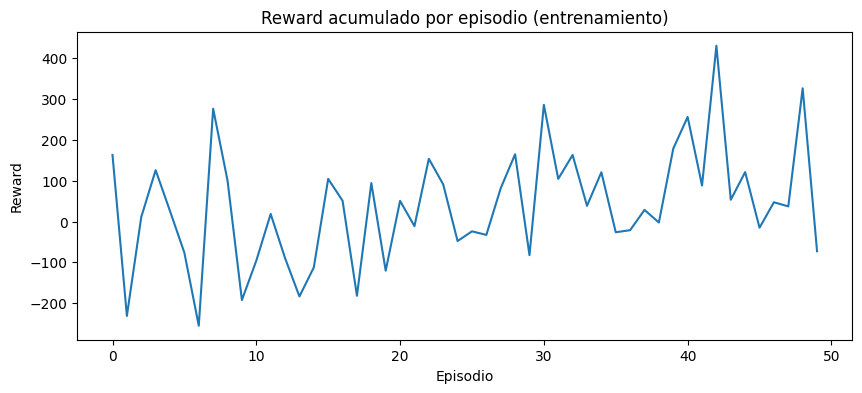

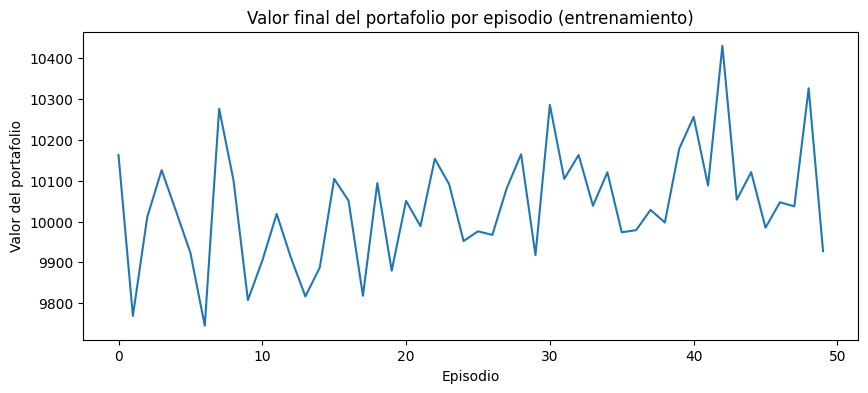

In [ ]:
import matplotlib.pyplot as plt
import time

# Hiperparámetros
num_episodes = 50gt
target_update_freq = 10  # Frecuencia para actualizar la red objetivo

# Preparar entorno y agente
state_dim = 5  # 4 features + inventory
action_dim = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

env = TradingEnv(train_data, initial_balance=10000)
agent = Agent(
    state_dim=state_dim, action_dim=action_dim, device=device,
    memory_size=3000, batch_size=64, gamma=0.99, lr=1e-3,
    epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.997
)

# Métricas de entrenamiento
episode_rewards = []
episode_assets = []
episode_epsilons = []

start_time = time.time()
for ep in range(1, num_episodes + 1):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        agent.replay()
        state = next_state
        total_reward += reward
    agent.update_epsilon()
    if ep % target_update_freq == 0:
        agent.update_target_net()
    # Guardar métricas
    episode_rewards.append(total_reward)
    episode_assets.append(env.total_asset)
    episode_epsilons.append(agent.epsilon)

    if ep % 25 == 0 or ep == 1:
      print(f"Episodio {ep}/{num_episodes} | Reward: {total_reward:.2f} | Asset final: {float(env.total_asset):.2f} | Epsilon: {agent.epsilon:.3f}")

print(f"Entrenamiento completado en {time.time() - start_time:.1f} segundos.")

# Graficar el reward por episodio
plt.figure(figsize=(10, 4))
plt.plot(episode_rewards)
plt.title('Reward acumulado por episodio (entrenamiento)')
plt.xlabel('Episodio')
plt.ylabel('Reward')
plt.show()

# Graficar el valor final del portafolio por episodio
plt.figure(figsize=(10, 4))
plt.plot(episode_assets)
plt.title('Valor final del portafolio por episodio (entrenamiento)')
plt.xlabel('Episodio')
plt.ylabel('Valor del portafolio')
plt.show()


# 7. BACKTESTING

/tmp/ipython-input-38-3000255294.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(row['Close_Norm']),
/tmp/ipython-input-38-3000255294.py:26: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(row['SMA_10_Norm']),
/tmp/ipython-input-38-3000255294.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(row['SMA_50_Norm']),
/tmp/ipython-input-38-3000255294.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(row['RSI_14_Norm']),
/tmp/ipython-input-38-3000255294.py:35: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. U

--- RESULTADOS EN BACKTEST ---
Valor final del portafolio (Agente RL): 9951.31
Retorno total (Agente RL): -0.49%
Valor final Buy & Hold: 13088.12
Retorno total Buy & Hold: 30.88%
Sharpe Ratio (Agente RL): -0.315
Win Rate (Agente RL): 41.55%


/tmp/ipython-input-38-3000255294.py:81: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  final_price = float(self.data.iloc[self.current_step]['Close'])
/tmp/ipython-input-42-3054077907.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  buy_and_hold_return = float((test_data['Close'].iloc[-1] - test_data['Close'].iloc[0]) / test_data['Close'].iloc[0] * 100)


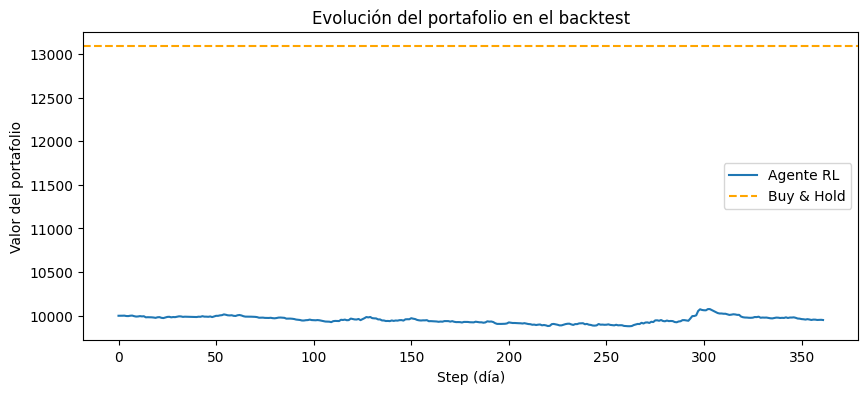

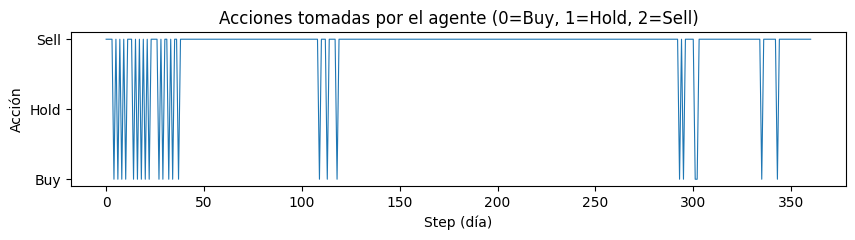

In [ ]:
import numpy as np

# Helper: Sharpe ratio
def sharpe_ratio(returns, risk_free=0):
    excess_returns = returns - risk_free
    return np.mean(excess_returns) / (np.std(excess_returns) + 1e-9) * np.sqrt(252)

# Backtesting
env_test = TradingEnv(test_data, initial_balance=10000)
state = env_test.reset()
agent.epsilon = 0  # Greedy, sin exploración
done = False

portfolio_values = [float(env_test.total_asset)]
actions_taken = []
rewards = []

while not done:
    action = agent.act(state)
    actions_taken.append(action)
    next_state, reward, done, info = env_test.step(action)
    rewards.append(reward)
    state = next_state
    portfolio_values.append(float(env_test.total_asset))

# Cálculo de métricas
retorno_total = (env_test.total_asset - env_test.initial_balance) / env_test.initial_balance * 100

# Buy & Hold para comparación
buy_and_hold_return = float((test_data['Close'].iloc[-1] - test_data['Close'].iloc[0]) / test_data['Close'].iloc[0] * 100)
buy_and_hold_final = float(10000 * (1 + buy_and_hold_return / 100))


# Rendimientos diarios del portafolio del agente
portfolio_values_arr = np.array(portfolio_values)
portfolio_returns = np.diff(portfolio_values_arr) / portfolio_values_arr[:-1]

# Sharpe ratio
sharpe = sharpe_ratio(portfolio_returns)

# Win rate (porcentaje de días con retorno positivo)
win_rate = (portfolio_returns > 0).mean() * 100

print(f"--- RESULTADOS EN BACKTEST ---")
print(f"Valor final del portafolio (Agente RL): {float(env_test.total_asset):.2f}")
print(f"Retorno total (Agente RL): {float(retorno_total):.2f}%")
print(f"Valor final Buy & Hold: {float(buy_and_hold_final):.2f}")
print(f"Retorno total Buy & Hold: {float(buy_and_hold_return):.2f}%")
print(f"Sharpe Ratio (Agente RL): {float(sharpe):.3f}")
print(f"Win Rate (Agente RL): {win_rate:.2f}%")

# Graficar valor del portafolio
plt.figure(figsize=(10, 4))
plt.plot(portfolio_values, label='Agente RL')
plt.axhline(float(buy_and_hold_final), color='orange', linestyle='--', label='Buy & Hold')
plt.title('Evolución del portafolio en el backtest')
plt.xlabel('Step (día)')
plt.ylabel('Valor del portafolio')
plt.legend()
plt.show()

# Graficar acciones tomadas
plt.figure(figsize=(10, 2))
plt.plot(actions_taken, lw=0.8)
plt.title('Acciones tomadas por el agente (0=Buy, 1=Hold, 2=Sell)')
plt.xlabel('Step (día)')
plt.ylabel('Acción')
plt.yticks([0, 1, 2], ['Buy', 'Hold', 'Sell'])
plt.show()


# 8. RESULTADOS Y GRÁFICOS FINALES

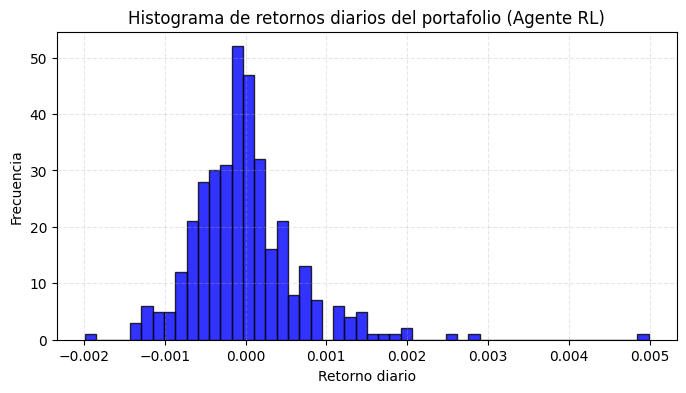

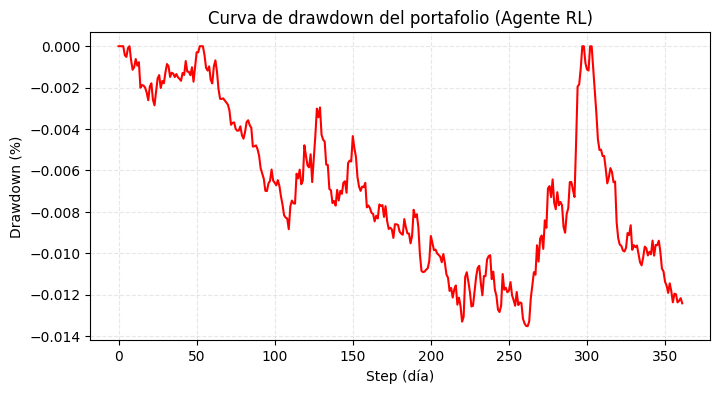

Drawdown máximo: -1.35%


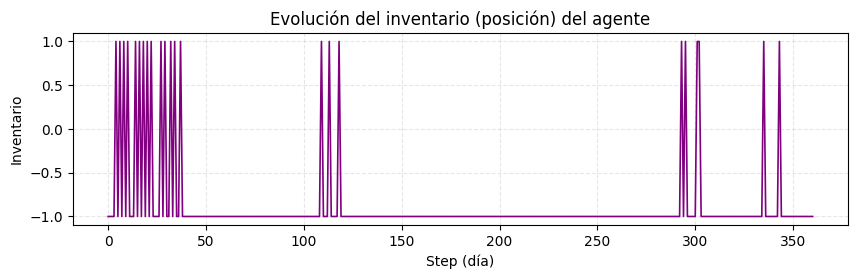

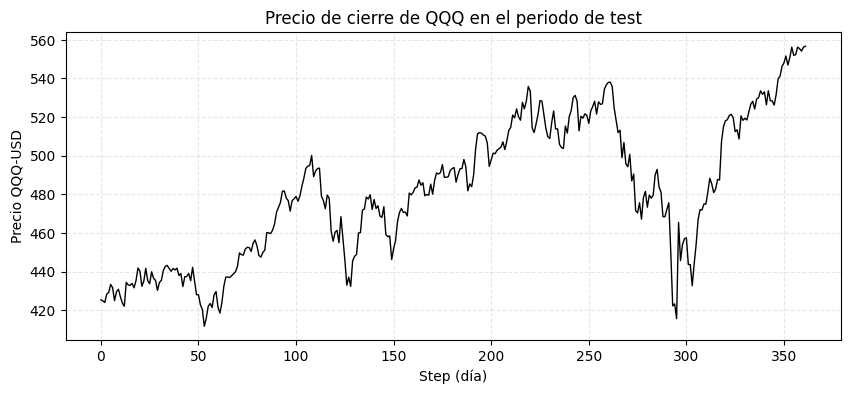

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Si no lo tienes ya:
portfolio_values_arr = np.array(portfolio_values)
portfolio_returns = np.diff(portfolio_values_arr) / portfolio_values_arr[:-1]

# === HISTOGRAMA DE RETORNOS DIARIOS ===
plt.figure(figsize=(8, 4))
plt.hist(portfolio_returns, bins=50, alpha=0.8, color='blue', edgecolor='k')
plt.title('Histograma de retornos diarios del portafolio (Agente RL)')
plt.xlabel('Retorno diario')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

# === CURVA DE DRAWDOWN ===
def compute_drawdown(values):
    running_max = np.maximum.accumulate(values)
    drawdown = (values - running_max) / running_max
    return drawdown

drawdowns = compute_drawdown(portfolio_values_arr)
plt.figure(figsize=(8, 4))
plt.plot(drawdowns, color='red')
plt.title('Curva de drawdown del portafolio (Agente RL)')
plt.xlabel('Step (día)')
plt.ylabel('Drawdown (%)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()
print(f"Drawdown máximo: {drawdowns.min()*100:.2f}%")

# === EVOLUCIÓN DEL INVENTARIO ===
# Puedes reconstruirlo desde las acciones tomadas si tu entorno los guarda,
# o agregar env_test.inventario_diario en el backtest.
# Aquí una versión reconstruida:
inventory_list = []
inventory = 0
for action in actions_taken:
    if action == 0:  # Buy
        if inventory == 0:
            inventory = 1  # abrir long
        elif inventory == -1:
            inventory = 1  # cerrar short y abrir long
        # Si ya está long, no cambia
    elif action == 2:  # Sell
        if inventory == 0:
            inventory = -1  # abrir short
        elif inventory == 1:
            inventory = -1  # cerrar long y abrir short
        # Si ya está short, no cambia
    # Hold no cambia nada
    inventory_list.append(inventory)


plt.figure(figsize=(10, 2.5))
plt.plot(inventory_list, color='purple', lw=1.2)
plt.title('Evolución del inventario (posición) del agente')
plt.xlabel('Step (día)')
plt.ylabel('Inventario')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

# === EVOLUCIÓN DEL PRECIO DE QQQ ===
plt.figure(figsize=(10, 4))
plt.plot(test_data['Close'].reset_index(drop=True), color='black', lw=1)
plt.title('Precio de cierre de QQQ en el periodo de test')
plt.xlabel('Step (día)')
plt.ylabel('Precio QQQ-USD')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


In [ ]:
print("======= RESUMEN FINAL DEL BACKTEST =======")
print(f"Valor final del portafolio (Agente RL): {float(env_test.total_asset):.2f}")
print(f"Retorno total (Agente RL): {float(retorno_total):.2f}%")
print(f"Valor final Buy & Hold: {float(buy_and_hold_final):.2f}")
print(f"Retorno total Buy & Hold: {buy_and_hold_return:.2f}%")
print(f"Sharpe Ratio (Agente RL): {sharpe:.3f}")
print(f"Win Rate (Agente RL): {win_rate:.2f}%")

======= RESUMEN FINAL DEL BACKTEST =======
Valor final del portafolio (Agente RL): 9951.31
Retorno total (Agente RL): -0.49%
Valor final Buy & Hold: 13088.12
Retorno total Buy & Hold: 30.88%
Sharpe Ratio (Agente RL): -0.315
Win Rate (Agente RL): 41.55%


# 9. DESCARGA EL MODELO ENTRENADO

In [ ]:

# Guardar el modelo entrenado
model_path = "dql_model.pth"
torch.save(agent.policy_net.state_dict(), model_path)
print(f"Modelo guardado en {model_path}")

Modelo guardado en dql_model.pth


In [ ]:
# Para cargar el modelo después:
# agent.policy_net.load_state_dict(torch.load(model_path))
# agent.policy_net.eval()

# 10. CONCLUSIÓN GENERAL


## Conclusión general

- **Retornos**  
  - Agente RL: **–0.49 %**  
  - Buy & Hold: **30.88 %**

- **Riesgo y consistencia**  
  - Sharpe Ratio: **–0.315**  
  - Win Rate: **41.6 %**  
  - Drawdown máximo: **–1.35 %**

- **Observaciones**  
  - El agente mantuvo el capital cerca del inicial, pero no capturó la fuerte tendencia alcista del QQQ.  
  - El entrenamiento (50 episodios) fue insuficiente para aprender patrones complejos.  
  - La función de recompensa solo considera PnL, sin incluir comisiones o penalizaciones.

- **Próximos pasos**  
  1. **Ampliar entrenamiento**: más episodios y datos históricos.  
  2. **Mejorar reward**: incluir costos de transacción y tiempo en posición.  
  3. **Optimizar arquitectura**: probar Double DQN, Dueling DQN o Prioritized Replay.  
  4. **Enriquecer el estado**: añadir indicadores (volumen, ATR, Bollinger, etc.).  
  5. **Validación cruzada**: backtests en otros periodos y activos para robustez.


# 11. CONCLUSIONES INDIVIDUALES

- Fernando: **Conclusión personal**  
Personalmente, al comparar el agente DQL con la estrategia Buy & Hold, veo que aún no logro superar el benchmark: el portafolio con RL terminó con –0.49 % (vs. +30.88 % de Buy & Hold), manteniendo el capital cerca del inicial pero sin capturar la tendencia alcista del QQQ. El Sharpe ratio negativo (–0.315), un win rate de 41.6 % y un drawdown máximo de –1.35 % reflejan una gestión conservadora y cierto sobreajuste a corto plazo. Reconozco que 50 episodios de entrenamiento y una función de recompensa basada únicamente en PnL limitan el aprendizaje. En adelante, planeo ampliar el número de episodios, añadir costos de transacción en el reward, probar arquitecturas como Double/Dueling DQN y enriquecer el estado con nuevos indicadores para buscar una mejora real en el rendimiento.  


- Marcos:

- Ricardo: Con los rendimientos que obtuvimos con el agente, creo que queda claro que en un periodo de 5 años, una estrategia pasiva como la de buy and hold va a tener, en mayoría, un rendimiento por encima de cualquier estrategia automática de aprendizaje de trading. Esto queda evidenciado por el hecho que se obtuvo un rendimiento muy por debajo de la estrategia pasiva. Con esto, puedo concluir que una estrategia avanzada de aprendizaje a veces puede llegar a ser más perjudicial que tomar una postura pasiva, especialmente en mercados con cambios estructurales sufridos por la pandemia, los cuales influyeron de manera importante al mercado. También, es probable que los bajos rendimientos del agente se deban a que una estrategia pasiva tiende a ser superior en periodos largos de tiempo. Se puede deducir que existe una acumulación de valor y la exposición a grandes "rallies" pueden llegar a favorecer las estrategias que se mantienen estáticas sin cambios muy abruptos o constantes.

  Por otro lado, creo que pudimos haber considerado hacer ciertas modificaciones a la hora de entrenar el agente, ya sea ajustando la selección de los features, incorporar penalizaciones por drawdowns grandes, limitar el número de operaciones (lo cual hicimos anteriormente, y sí mejoró considerablemente los resultados), o incorporando optimización de temporalidades.